# Amazon Reviews

## A look into the data and its distribution

Dataset taken from: http://jmcauley.ucsd.edu/data/amazon/

In [4]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz

--2020-02-14 02:43:50--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 708988936 (676M) [application/x-gzip]
Saving to: ‘reviews_Movies_and_TV_5.json.gz’

reviews_Movies_and_ 100%[===================>] 676,14M  4,08MB/s    in 2m 29s  

2020-02-14 02:46:20 (4,53 MB/s) - ‘reviews_Movies_and_TV_5.json.gz’ saved [708988936/708988936]



In [6]:
!sha256sum --check reviews_Movies_and_TV_5.json.gz.sha256

reviews_Movies_and_TV_5.json.gz: OK


In [1]:
%matplotlib inline

import imblearn.under_sampling
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse
import seaborn as sns
import sklearn.feature_extraction.text
import sklearn.model_selection

In [8]:
df = pd.read_json('reviews_Movies_and_TV_5.json.gz', lines=True)

In [4]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,"12 22, 2013"
...,...,...,...,...,...,...,...,...,...
1697528,AV657BUYHHXZ2,B00LT1JHLW,"Mike Rules ""Mike""","[1, 14]",wow $269.99 for the entire series on Blu Ray??...,1,Way to Expensive!! WB = GREED,1406073600,"07 23, 2014"
1697529,A17W587EH23J0Q,B00LT1JHLW,"Ron2900 ""Ron""","[32, 48]","Finally, the holy grail of tv-on-dvd boxsets i...",5,"HOLY BAT-BOXSET, BATMAN... I never thought thi...",1405641600,"07 18, 2014"
1697530,A3DE438TF1A958,B00LT1JHLW,thomas henry,"[3, 10]",Could this be a true or I'm i dreaming batman ...,5,prayers have been answered because batman 60s ...,1405728000,"07 19, 2014"
1697531,A2RWCXDMANY0LW,B00LT1JHLW,wheev,"[0, 4]",I've been a fan of the series since I was a yo...,5,can't Wait!,1405987200,"07 22, 2014"


### Getting rid of empty reviews

In [5]:
df = df[df['reviewText'] != '']
df.shape

(1697471, 9)

### Overall rating

In [6]:
five = df[df['overall'] == 5].count()
four = df[df['overall'] == 4].count()
three = df[df['overall'] == 3].count()
two = df[df['overall'] == 2].count()
one = df[df['overall'] == 1].count()

one[0], two[0], three[0], four[0], five[0]

(104215, 102406, 201294, 382982, 906574)

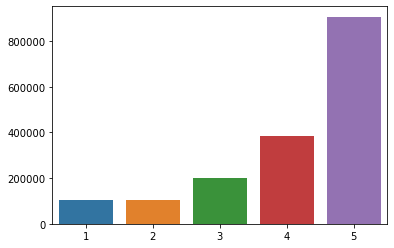

In [7]:
sns.barplot(x=[1, 2, 3, 4, 5], y=[df[df['overall'] == rating].count()[0] for rating in range(1, 5+1)])

### Arbitrary split to 25% test samples and 75% training ones

In [8]:
train, test = sklearn.model_selection.train_test_split(df, test_size=0.25)

In [9]:
train.shape, test.shape

((1273103, 9), (424368, 9))

Text(0.5, 1.0, 'test')

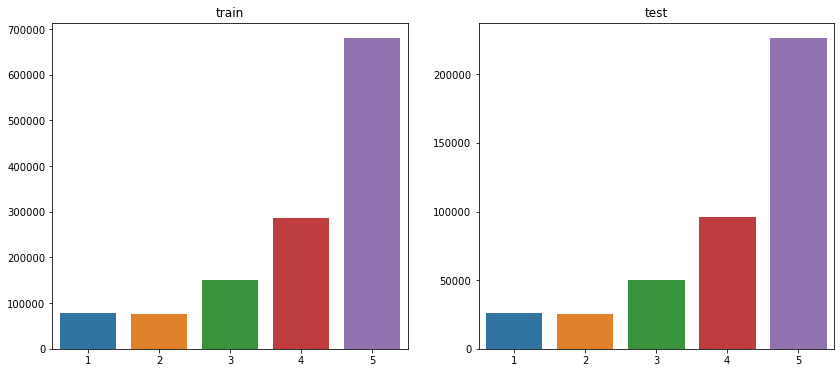

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(
    x=[1, 2, 3, 4, 5],
    y=[train[train['overall'] == rating].count()[0] for rating in range(1, 5+1)], ax=ax[0]).set_title('train')

sns.barplot(
    x=[1, 2, 3, 4, 5],
    y=[test[test['overall'] == rating].count()[0] for rating in range(1, 5+1)], ax=ax[1]).set_title('test')

#### Random downsampling of the overrepresented classes

In [11]:
downsampled_train_df = pd.concat([
    train[train['overall'] == 1],
    train[train['overall'] == 2],
    train[train['overall'] == 3].sample(80_000),
    train[train['overall'] == 4].sample(80_000),
    train[train['overall'] == 5].sample(80_000),
])

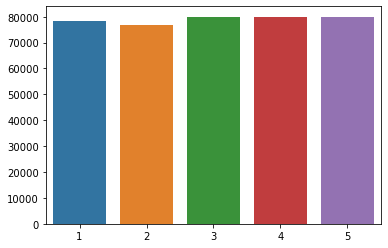

In [12]:
sns.barplot(
    x=[1, 2, 3, 4, 5],
    y=[downsampled_train_df[downsampled_train_df['overall'] == rating].count()[0] for rating in range(1, 5+1)])

#### Crude oversamplying, done by simply copying the data

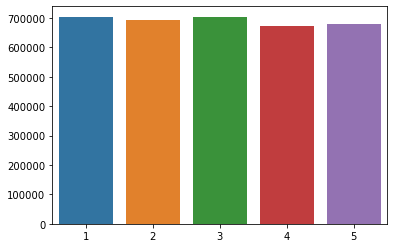

In [13]:
oversampled_train_df = pd.concat([
    train[train['overall'] == 1],
    train[train['overall'] == 1],
    train[train['overall'] == 1],
    train[train['overall'] == 1],
    train[train['overall'] == 1],
    train[train['overall'] == 1],
    train[train['overall'] == 1],
    train[train['overall'] == 1],
    train[train['overall'] == 1],
    train[train['overall'] == 2],
    train[train['overall'] == 2],
    train[train['overall'] == 2],
    train[train['overall'] == 2],
    train[train['overall'] == 2],
    train[train['overall'] == 2],
    train[train['overall'] == 2],
    train[train['overall'] == 2],
    train[train['overall'] == 2],
    train[train['overall'] == 3],
    train[train['overall'] == 3],
    train[train['overall'] == 3],
    train[train['overall'] == 3],
    train[train['overall'] == 3].sample(100_000),
    train[train['overall'] == 4],
    train[train['overall'] == 4],
    train[train['overall'] == 4].sample(100_000),
    train[train['overall'] == 5],
])

sns.barplot(
    x=[1, 2, 3, 4, 5],
    y=[oversampled_train_df[oversampled_train_df['overall'] == rating].count()[0] for rating in range(1, 5+1)])

#### Dump the downsampled and stripped datasets to disk

In [14]:
unnecessary_columns = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime', 'summary']

with open('full_train.csv', 'w') as f:
    f.write(train.drop(unnecessary_columns, axis=1).to_csv())

with open('downsampled_train.csv', 'w') as f:
    f.write(downsampled_train_df.drop(unnecessary_columns, axis=1).to_csv())

with open('oversampled_train.csv', 'w') as f:
    f.write(oversampled_train_df.drop(unnecessary_columns, axis=1).to_csv())

with open('test.csv', 'w') as f:
    f.write(test.drop(unnecessary_columns, axis=1).to_csv())

#### Synthetic resampling - Tomek's Links and SMOTE

In [13]:
full_count_X = scipy.sparse.load_npz('vectorized/full-count-none-TRAIN.npz')
full_count_X

<1273103x685167 sparse matrix of type '<class 'numpy.int64'>'
	with 122754086 stored elements in Compressed Sparse Row format>

In [8]:
full_tf_idf_X = scipy.sparse.load_npz('vectorized/full-tf_idf-none-TRAIN.npz')
full_tf_idf_X

<1273103x685167 sparse matrix of type '<class 'numpy.float64'>'
	with 122754086 stored elements in Compressed Sparse Row format>

In [14]:
train_targets = pd.read_csv('full_train.csv')['overall'].values
train_targets.shape

(1273103,)

In [15]:
scipy.sparse.load_npz('vectorized/full-count-none-TRAIN.npz').shape

(1273103, 685167)

In [18]:
#tomek_count = imblearn.under_sampling.TomekLinks(sampling_strategy=[3, 4, 5], n_jobs=-1)
#tomek_count_X, tomek_count_Y = tomek_count.fit_resample(scipy.sparse.load_npz('vectorized/full-count-none-TRAIN.npz'), train_targets)
print('count stomkowany')

tomek_tf_idf = imblearn.under_sampling.TomekLinks(sampling_strategy=[3, 4, 5], n_jobs=-1)
tomek_tf_idf_X, tomek_tf_idf_Y = tomek_tf_idf.fit_resample(scipy.sparse.load_npz('vectorized/full-tf_idf-none-TRAIN.npz'), train_targets)
print('tf-idf stomkowany')

count stomkowany


KeyboardInterrupt: 

In [10]:
tomek_count

TomekLinks(n_jobs=-1, sampling_strategy=[3, 4, 5])

### "Helpfulness"

In [15]:
df[['helpful_voted', 'helpful_out_of']] = pd.DataFrame(df['helpful'].values.tolist())
df

/home/asgavar/.local/lib/python3.8/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_voted,helpful_out_of
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,"02 26, 2008",0.0,0.0
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,"12 30, 2013",0.0,0.0
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,"12 30, 2013",0.0,0.0
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008",0.0,0.0
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,"12 22, 2013",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1697528,AV657BUYHHXZ2,B00LT1JHLW,"Mike Rules ""Mike""","[1, 14]",wow $269.99 for the entire series on Blu Ray??...,1,Way to Expensive!! WB = GREED,1406073600,"07 23, 2014",NaN,NaN
1697529,A17W587EH23J0Q,B00LT1JHLW,"Ron2900 ""Ron""","[32, 48]","Finally, the holy grail of tv-on-dvd boxsets i...",5,"HOLY BAT-BOXSET, BATMAN... I never thought thi...",1405641600,"07 18, 2014",NaN,NaN
1697530,A3DE438TF1A958,B00LT1JHLW,thomas henry,"[3, 10]",Could this be a true or I'm i dreaming batman ...,5,prayers have been answered because batman 60s ...,1405728000,"07 19, 2014",NaN,NaN
1697531,A2RWCXDMANY0LW,B00LT1JHLW,wheev,"[0, 4]",I've been a fan of the series since I was a yo...,5,can't Wait!,1405987200,"07 22, 2014",NaN,NaN


In [16]:
df['helpfulness'] = (df['helpful_voted'] / df['helpful_out_of']).fillna(1.1)
df[df['helpfulness'] > 1.1] = -0.1

<ipython-input-16-aa199c44962a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['helpfulness'] = (df['helpful_voted'] / df['helpful_out_of']).fillna(1.1)
<ipython-input-16-aa199c44962a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['helpfulness'] > 1.1] = -0.1
/home/asgavar/.local/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

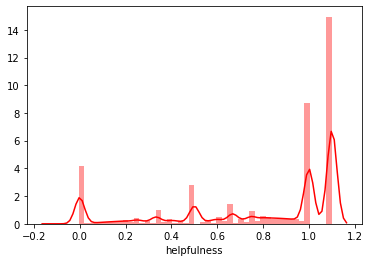

In [17]:
sns.distplot(df['helpfulness'], kde='false', color='red')